In [17]:
import numpy as np
import random
from keras import callbacks
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import string
from typing import List, Tuple
import re

In [18]:
import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res


In [19]:
def create_x_y(songs, tokenize, total_words, max_len) -> Tuple[np.ndarray, np.ndarray]:
    input_sequences = []
    for line in songs:
        token_list = tokenize.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i + 1]
            input_sequences.append(n_gram_sequence)
    print(input_sequences[:10])
    max_sequence_len = max([len(x) for x in input_sequences])
    # input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
    x_train = input_sequences[:, :-1]
    y_train = input_sequences[:, -1]
    y_train = utils.to_categorical(y_train, num_classes=total_words)
    return x_train, y_train

def create_x_y_train(songs, tokenize, total_words) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    random.shuffle(songs)
    val_songs = songs[:120]
    train_songs = songs[120:]
    # input_sequences = []
    # for line in songs:
    #     token_list = tokenize.texts_to_sequences([line])[0]
    #     for i in range(1, len(token_list)):
    #         n_gram_sequence = token_list[:i + 1]
    #         input_sequences.append(n_gram_sequence)
    # print(input_sequences[:10])
    # max_sequence_len = max([len(x) for x in input_sequences])
    # # input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    # input_sequences = np.array(pad_sequences(input_sequences, maxlen=100, padding='pre'))
    # x_train = input_sequences[:, :-1]
    # y_train = input_sequences[:, -1]
    # y_train = utils.to_categorical(y_train, num_classes=total_words)
    max_len = 5
    x_t, y_t = create_x_y(train_songs, tokenize, total_words, max_len)
    x_v, y_v = create_x_y(val_songs, tokenize, total_words, max_len)
    return x_t, y_t, x_v, y_v, max_len


import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res

def load_songs(path, pop_305=True) -> List[str]:
    df = load_lyrics(path)
    songs = []
    for song in list(df['lyrics']):
        song += " EOF"
        # remove '(*)'
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = modified_song.replace("chorus", "").lower()
        # modified_song = modified_song.replace("chorus", "").replace("&", "silencio").lower()
        # modified_song = modified_song.replace("&", "silencio").lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        modified_song = regex.sub('', modified_song)
        songs.append(modified_song)
    if pop_305:
        songs.pop(305)
    return songs

def remove_words(words: List[str], songs):
    resulting_songs = []
    for song in songs:
        result = song
        for word in words:
            result = result.replace(word, '')
        resulting_songs.append(result)
    return resulting_songs

In [20]:
class LyricsGenerator(object):

    def __init__(self, embedding_dim: int, vocab_size: int, input_size: int, embedding_matrix: np.ndarray):
        embedding_layer = Embedding(
            vocab_size,
            embedding_dim,
            input_length=input_size,
            weights=[embedding_matrix],
            # embeddings_initializer=initializers.Constant(embedding_matrix),
            trainable=False,
        )

        self.model = Sequential()
        self.model.add(embedding_layer)
        self.model.add(LSTM(units=embedding_dim))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=vocab_size, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def fit(self, x, y, hyper_parameters):
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback3 = callbacks.ModelCheckpoint('lyrics_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        # history = self.model.fit(x, y, epochs=100, verbose=1)
        history = self.model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                 callbacks=[callback],
                                 # callbacks=[callback, callback2],
                                 verbose=1, validation_split=hyper_parameters['validation_split'],
                                 validation_data=hyper_parameters['val_data'])
        self.model.save('lyrics_model.h5')
        
        return history

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
embedding_matrixs =  np.load("/content/drive/MyDrive/DL/Assignment_3/Lyrics/embedding_matrix_glove.npy")
embedding_matrixs.shape

(7527, 300)

In [23]:
songs = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_train_set.csv')
test_songs = load_songs("/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_test_set.csv", pop_305=False)

# Data preprocessing
tokenize = Tokenizer()
tokenize.fit_on_texts(songs)
total_words = len(tokenize.word_index) + 1

In [24]:
# import tensorflow as tf
# import random
# tf.random.set_seed(1)
# random.seed(2)
# np.random.seed(3)
import json
non_words_dict = json.load(open('/content/drive/MyDrive/DL/Assignment_3/Lyrics/non_words.json', "r"))
non_words_list = non_words_dict["non existing words"]
cleaned_songs = remove_words(non_words_list, songs)
cleaned_test_songs = remove_words(non_words_list, test_songs)
print(len(cleaned_songs))
print(len(cleaned_test_songs))


599
5


In [25]:
# # Data preprocessing
# tokenize = Tokenizer()
# tokenize.fit_on_texts(cleaned_songs)
# total_words = len(tokenize.word_index) + 1

embedding_dim = 300
x_train, y_train, x_val, y_val, max_sequence_len = create_x_y_train(cleaned_songs, tokenize, total_words)
x_test, y_test = create_x_y(cleaned_test_songs, tokenize, total_words, max_sequence_len)


[[36, 1], [36, 1, 38], [36, 1, 38, 40], [36, 1, 38, 40, 3], [36, 1, 38, 40, 3, 44], [36, 1, 38, 40, 3, 44, 10], [36, 1, 38, 40, 3, 44, 10, 36], [36, 1, 38, 40, 3, 44, 10, 36, 1], [36, 1, 38, 40, 3, 44, 10, 36, 1, 81], [36, 1, 38, 40, 3, 44, 10, 36, 1, 81, 28]]
[[649, 4], [649, 4, 2], [649, 4, 2, 102], [649, 4, 2, 102, 2], [649, 4, 2, 102, 2, 577], [649, 4, 2, 102, 2, 577, 16], [649, 4, 2, 102, 2, 577, 16, 56], [649, 4, 2, 102, 2, 577, 16, 56, 61], [649, 4, 2, 102, 2, 577, 16, 56, 61, 529], [649, 4, 2, 102, 2, 577, 16, 56, 61, 529, 3766]]
[[330, 12], [330, 12, 112], [330, 12, 112, 110], [330, 12, 112, 110, 7], [330, 12, 112, 110, 7, 12], [330, 12, 112, 110, 7, 12, 271], [330, 12, 112, 110, 7, 12, 271, 636], [330, 12, 112, 110, 7, 12, 271, 636, 28], [330, 12, 112, 110, 7, 12, 271, 636, 28, 1], [330, 12, 112, 110, 7, 12, 271, 636, 28, 1, 77]]


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4, 300)            2258100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 7527)              2265627   
Total params: 5,244,927
Trainable params: 2,986,827
Non-trainable params: 2,258,100
_________________________________________________________________
Epoch 1/15
240/240 [==============================] - 9s 30ms/step - loss: 6.7755 - accuracy: 0.0404 - val_loss: 6.1346 - val_accuracy: 0.0615
Epoch 2/15
240/240 [==============================] - 7s 28ms/step - loss: 5.8156 - accurac

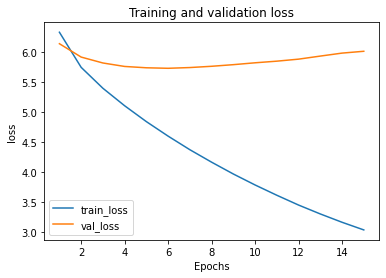

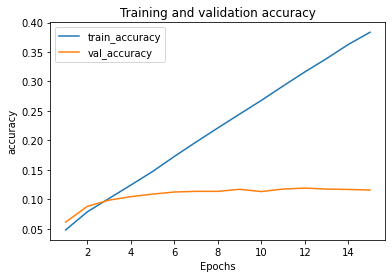

In [30]:
# Train model

parameters = {
    'batch_size' : 512 ,
    'validation_split' : None ,
    'epochs' : 15 ,
    'val_data' :  (x_val, y_val)
}
lyrics_generator = LyricsGenerator(embedding_dim, total_words, x_train.shape[1], embedding_matrixs)
h = lyrics_generator.fit(x_train, y_train, parameters)
lyrics_generator.plot_metric(h)
lyrics_generator.plot_metric(h, metric="accuracy")

In [27]:
prediction = lyrics_generator.evaluate(x_test, y_test)
print(prediction)

34/34 [==============================] - 0s 4ms/step - loss: 6.2135 - accuracy: 0.1145
[6.2135467529296875, 0.11447492986917496]


In [28]:
def generate_text(seed_text, eof, model, max_sequence_len, vocab_size):
    next_word = ""
    word_indices = np.arange(vocab_size) + 1
    while next_word != eof:
        token_list = tokenize.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_proba = model.model.predict_proba(token_list, verbose=0)
        # print(predicted_proba.reshape((predicted_proba.shape[1])).shape)
        # sample the word index acording to predicted proba
        chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))

        
        next_word = ""
        for word, index in tokenize.word_index.items():
            if index == chosen_index:     
                next_word = word
                # print(next_word)
                break
        seed_text += " " + next_word
    return seed_text

In [29]:
print(generate_text('forgive' , "eof" , lyrics_generator , max_sequence_len, total_words))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


forgive my reminds here i hope the the there be me a loving can thats up a faith for i to was its through i stand and in i till why this apart and from i but everyone love slept girl a work it like of my whoa like eof
